<a href="https://colab.research.google.com/github/Kim-Jeong-Ju/AI_Modeling_NLP/blob/main/Attention_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Packages and Modules Importation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import re
import urllib3
import shutil
import zipfile
import gzip
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences, skipgrams
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Activation, Flatten, Attention
from tensorflow.keras.utils import to_categorical, plot_model

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Attention Mechanism, 어텐션 메커니즘**  


---

- Seq2Seq 모델은 **하나의 고정 길이 벡터에 모든 정보를 압축**하므로 **정보의 손실** 발생
- Seq2Seq 모델은 RNN의 고질적인 문제인 **Gradient Vanishing Problem 존재**
- Seq2Seq 모델의 단점을 개선하고자 **Attention Mechanism이 탄생**
- Attention Mechanism에서는 **Decoder의 매 시점마다 Encoder의 전체 입력 문장을 다시 참조**
- 특히 전체 입력 문장 중 **예측할 단어와 연관이 있는 단어에 집중(Attention)**하여 참조

## **Type of Attention Mechanism**  
Attention Mechanism에는 스코어 계산 방식의 차이에 따라 다양한 종류가 존재  
  

이 름                 | 스 코 어&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                 
----------------------|-----------------------
dot|$score(s_t, h_i) = s_t^Th_i$
scaled dot|$score(s_t, h_i) = \frac{s_t^Th_i}{\sqrt n}$
general|$score(s_t, h_i) = s_t^TW_ah_i$
concat|$score(s_t, h_i) = W_a^Ttanh(W_b[s_t;h_i])$
location-base|$a_t = softmax(W_as_t)$  
  
  + $s_t$ : Querys(t 시점에서의 디코더 셀의 은닉 상태)
  + $h_i$ : Keys(모든 시점의 인코더 셀 은닉 상태)
  + $W_a, W_b$ : 학습 가능한 가중치 행렬

## **Process of Attention Mechanism**  


---

### **Dot Product Attention Mechanism 동작 과정**
  **1. Attention Score 계산**  
  **2. softmax activation 함수**를 통한 **Attention Distribution** 계산  
  **3. 각 Encoder의 Attention Weights**와 **hidden_state를 가중합**하여 **Attention Value** 계산  
  **4. Attention Value**과 Decoder의 t 시점의 **hidden_state를 Concatenation**  
  **5.** 출력층 연산의 입력이 되는 **$\tilde{s}_t$ 계산**  
  
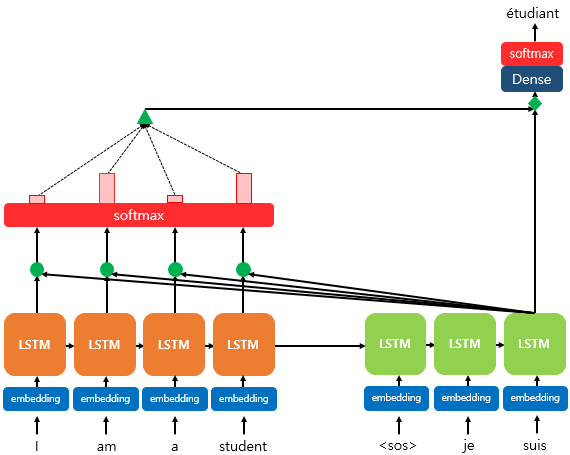

### **Attention Score 계산 과정**  
**1.** t 시점 Decoder의 hidden_state를 **$s_t$로 지정**  
**2.** Encoder의 각 시점의 hidden_state는 **$h_n$으로 지정**  
**3.** $s_t$와 $h_n$들을 **각각 내적해 각각의 Attention Score를 계산**   
**4.** 이를 정리하면 **Attention Scores = $e^t = [s_t^Th_1, s_t^Th_2, ... , s_t^Th_n$]**  
  

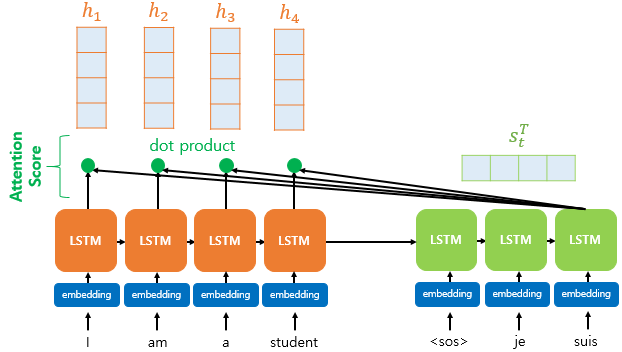

### **Attention Distribution 계산 과정**  
**1.** $e^t = [s_t^Th_1, s_t^Th_2, ... , s_t^Th_n$]에 **softmax를 적용해 각각의 확률값을 계산**  
**2.** 내적이 크다면 확률값이 높아질 것이고, 작다면 확률값이 낮아짐  
**3.** 결국 확률값을 구하는 것은 예측할 단어와 연관이 있는 단어를 찾는 것   
**4.** **시점 t의 어텐션 분포를 $a^t$**이라고 하면, 다음과 같은 식이 성립함  
  $$ a^t = softmax(e^t) $$
  
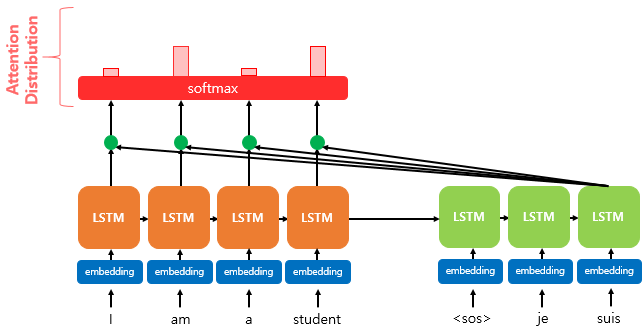

### **Attention Value와 Decoder의 t 시점과 Concatenation**  
**1.** Attention Value $a_t$를 구했다면 **$s_t$와 연결해 예측 연산에 사용**할 $v_t$를 계산함  
**2.** $v_t$는 기존과는 다르게 **Encoder의 정보를 가지고 있어 좀 더 좋은 성능의 예측**을 수행할 수 있음  
  
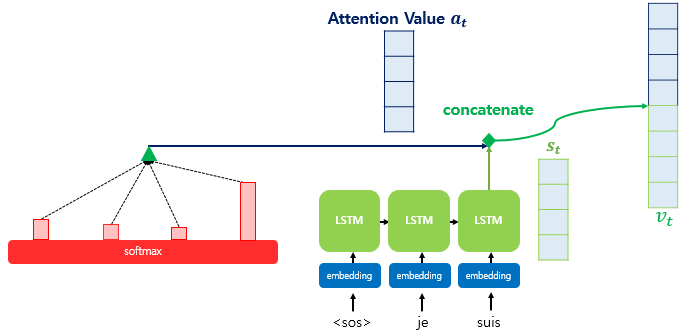

## **Model of Attention Mechanism**

In [2]:
## Dataset 구성 및 Pre-Processing

http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)

with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']
lines = lines.loc[:, 'src':'tar']    
lines = lines[0:60000] 
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')

src_vocab = set()
for line in lines.src:
    for char in line:
        src_vocab.add(char)
tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])

encoder_input = []
for line in lines.src:
  encoder_input.append([src_to_index[w] for w in line])

decoder_input = []
for line in lines.tar:
  decoder_input.append([tar_to_index[w] for w in line])

decoder_target = []
for line in lines.tar:
  decoder_target.append([tar_to_index[w] for w in line if w != '\t'])

max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])

encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [3]:
## Encoder 및 Decoder, Attention Mechanism 설계

encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
print('hidden_state.shape = ', state_h.shape)
print('decoder_outputs.shape = ', decoder_outputs.shape)
print()

S_ = tf.concat([state_h[:, tf.newaxis, :], decoder_outputs[:, :-1, :]], axis=1)
print('dimension_changed_hidden_state.shape = ', state_h[:, tf.newaxis, :].shape)
print('S_.shape = ', S_.shape)
print()

attention = Attention()
context_vector = attention([S_, encoder_outputs])
concat = tf.concat([decoder_outputs, context_vector], axis=-1)
print('context_vector.shape = ', context_vector.shape)
print('concat.shape = ', concat.shape)
print()

decoder_softmax_layer = Dense(tar_vocab_size, activation="softmax")
decoder_outputs = decoder_softmax_layer(concat)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
print()

model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=128, epochs=30, validation_split=0.2)

hidden_state.shape =  (None, 256)
decoder_outputs.shape =  (None, None, 256)

dimension_changed_hidden_state.shape =  (None, 1, 256)
S_.shape =  (None, None, 256)

context_vector.shape =  (None, None, 256)
concat.shape =  (None, None, 512)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 79)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        344064      ['input_1[0][0]']                
                                 (None, 256),      

In [4]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, encoder_states])

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
estate_h = Input(shape=(256,))
encoder_outputs = Input(shape=(256,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]    
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

S_ = tf.concat([estate_h[:, tf.newaxis, :], decoder_outputs[:, :-1, :]], axis=1)
context_vector = attention([S_, encoder_outputs])
decoder_concat = tf.concat([decoder_outputs, context_vector], axis=-1)
decoder_outputs = decoder_softmax_layer(decoder_concat)
decoder_model = Model(inputs=[decoder_inputs, estate_h, encoder_outputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

def predict_decode(input_seq):
    outputs_input, states_value = encoder_model.predict(input_seq)    # outputs_input이 추가됨

    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1

    stop_cond = False
    decoded_sent = ""

    while not stop_cond:
        output_tokens, h, c = decoder_model.predict([target_seq, states_value[0], outputs_input] + states_value)    # states_value[0]와 outputs_input이 추가됨

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        decoded_sent += sampled_char
        print(f'Decoded Sentence = {decoded_sent}')

        if (sampled_char == '\n' or
            len(decoded_sent) > max_tar_len):
            stop_cond = True

        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sent

for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sent = predict_decode(input_seq)
    
    print('입력 문장 = ', lines.src[seq_index])
    print('정답 문장 = ', lines.tar[seq_index][2:len(lines.tar[seq_index])-1])
    print('번역 문장 = ', decoded_sent[1:len(decoded_sent)-1])
    print(35 * "-")
    print()
    print()

1/1 [==============================] - 0s 383ms/step
Decoded Sentence =  
1/1 [==============================] - 0s 18ms/step
Decoded Sentence =  D
1/1 [==============================] - 0s 17ms/step
Decoded Sentence =  Dé
1/1 [==============================] - 0s 17ms/step
Decoded Sentence =  Dég
1/1 [==============================] - 0s 18ms/step
Decoded Sentence =  Déga
1/1 [==============================] - 0s 18ms/step
Decoded Sentence =  Dégag
1/1 [==============================] - 0s 19ms/step
Decoded Sentence =  Dégage
1/1 [==============================] - 0s 19ms/step
Decoded Sentence =  Dégage 
1/1 [==============================] - 0s 18ms/step
Decoded Sentence =  Dégage !
1/1 [==============================] - 0s 17ms/step
Decoded Sentence =  Dégage ! 
1/1 [==============================] - 0s 18ms/step
Decoded Sentence =  Dégage ! 

입력 문장 =  Go.
정답 문장 =  Bouge ! 
번역 문장 =  Dégage ! 
-----------------------------------


1/1 [==============================] - 0s 18ms/step
D